# Import Library



1.   Import Library
2.   EDA
3.   Data Preprocessing
4.   Modelling



In [ ]:
# Import library yang akan digunakan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Ganti default directory
#default_dir = "/content/drive/MyDrive/IndonesiaAI/Project 3"
#os.chdir(default_dir)

# Load the dataset
df_train = pd.read_csv('/content/drive/MyDrive/IndonesiaAI/Project 3/train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

In [ ]:
df_train
df_train.info()
df_train.describe()
df_train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 252 entries, Id to SaleCondition_Partial
dtypes: bool(214), float64(4), int64(34)
memory usage: 738.7 KB


,0
Id,0
MSSubClass,0
LotFrontage,0
LotArea,0
OverallQual,0
OverallCond,0
YearBuilt,0
YearRemodAdd,0
MasVnrArea,0
BsmtFinSF1,0


In [ ]:
# Handle missing values
df_train = df_train.fillna({
    'LotFrontage': df_train['LotFrontage'].median(),
    'Alley': 'None',
    'MasVnrType': 'None',
    'MasVnrArea': 0,
    'BsmtQual': 'TA',
    'BsmtCond': 'TA',
    'BsmtExposure': 'No',
    'BsmtFinType1': 'Unf',
    'BsmtFinType2': 'Unf',
    'Electrical': df_train['Electrical'].mode()[0],
    'FireplaceQu': 'None',
    'GarageType': 'Attchd',
    'GarageYrBlt': df_train['GarageYrBlt'].median(),
    'GarageFinish': 'Unf',
    'GarageQual': 'TA',
    'GarageCond': 'TA',
    'PoolQC': 'None',
    'Fence': 'None',
    'MiscFeature': 'None'
})

In [ ]:
df_train['PoolQC'].value_counts()

,count
PoolQC,
Gd,3
Ex,2
Fa,2


Contoh SD : 1,  SMP : 2, SMA : 3




In [ ]:
# One-Hot Encoding untuk kolom kategorikal (hanya Kolom Kategorikal yang tipenya Nominal)
df_train = pd.get_dummies(df_train, drop_first=True)


#Dipisah numric, kategorik ordinal, kategorik nominal, date dll

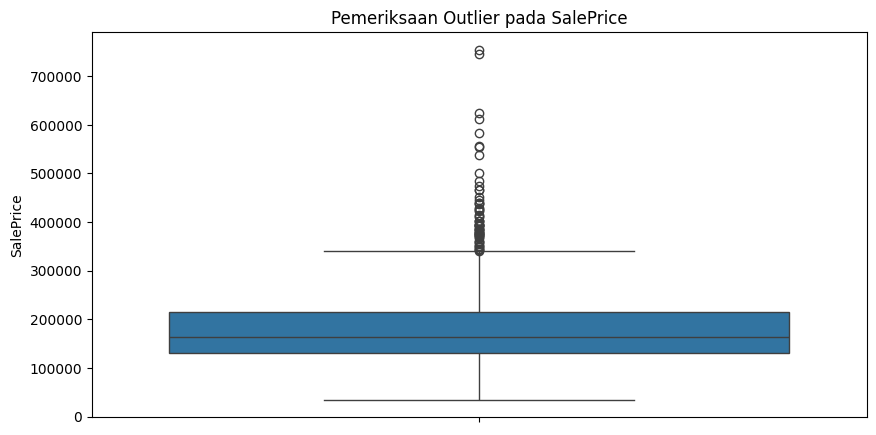


Observasi Outlier pada SalePrice:
        Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
11      12          60         85.0    11924            9            5   
53      54          20         68.0    50271            9            5   
58      59          60         66.0    13682           10            5   
112    113          60         77.0     9965            7            5   
151    152          20        107.0    13891            8            5   
...    ...         ...          ...      ...          ...          ...   
1268  1269          50         69.0    14100            8            9   
1353  1354          50         56.0    14720            8            5   
1373  1374          20         69.0    11400           10            5   
1388  1389          20         42.0    14892            9            5   
1437  1438          20         96.0    12444            8            5   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLI  

<ipython-input-7-aaa1e3c7608e>:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '340037.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train["SalePrice"] > upper_bound, "SalePrice"] = upper_bound


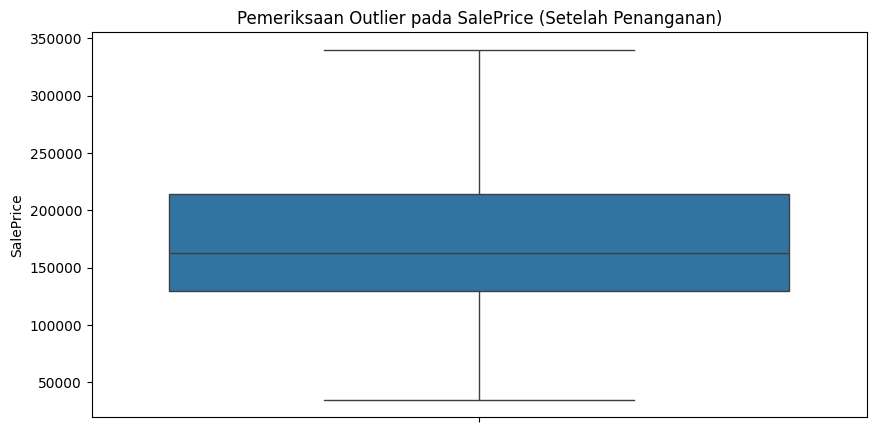

(1460, 252)

In [ ]:
# Cek Outlier SalePrice
plt.figure(figsize=(10, 5))
sns.boxplot(df_train["SalePrice"])
plt.title('Pemeriksaan Outlier pada SalePrice')
plt.show()

df_train.shape

# Menghitung IQR untuk SalePrice
Q1 = df_train["SalePrice"].quantile(0.25)
Q3 = df_train["SalePrice"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menampilkan observasi outlier
print("\nObservasi Outlier pada SalePrice:")
outliers = df_train.loc[(df_train["SalePrice"] > upper_bound) | (df_train["SalePrice"] < lower_bound)]
print(outliers)

# Mengganti outlier dengan batas atas dan bawah
df_train.loc[df_train["SalePrice"] > upper_bound, "SalePrice"] = upper_bound
df_train.loc[df_train["SalePrice"] < lower_bound, "SalePrice"] = lower_bound

# Cek Outlier pada SalePrice setelah penanganan
plt.figure(figsize=(10, 5))
sns.boxplot(df_train["SalePrice"])
plt.title('Pemeriksaan Outlier pada SalePrice (Setelah Penanganan)')
plt.show()

df_train.shape

In [ ]:
# Memisahkan antara fitur (X) dan target (y)
X = df_train.drop(columns=['SalePrice'])
y = df_train['SalePrice']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

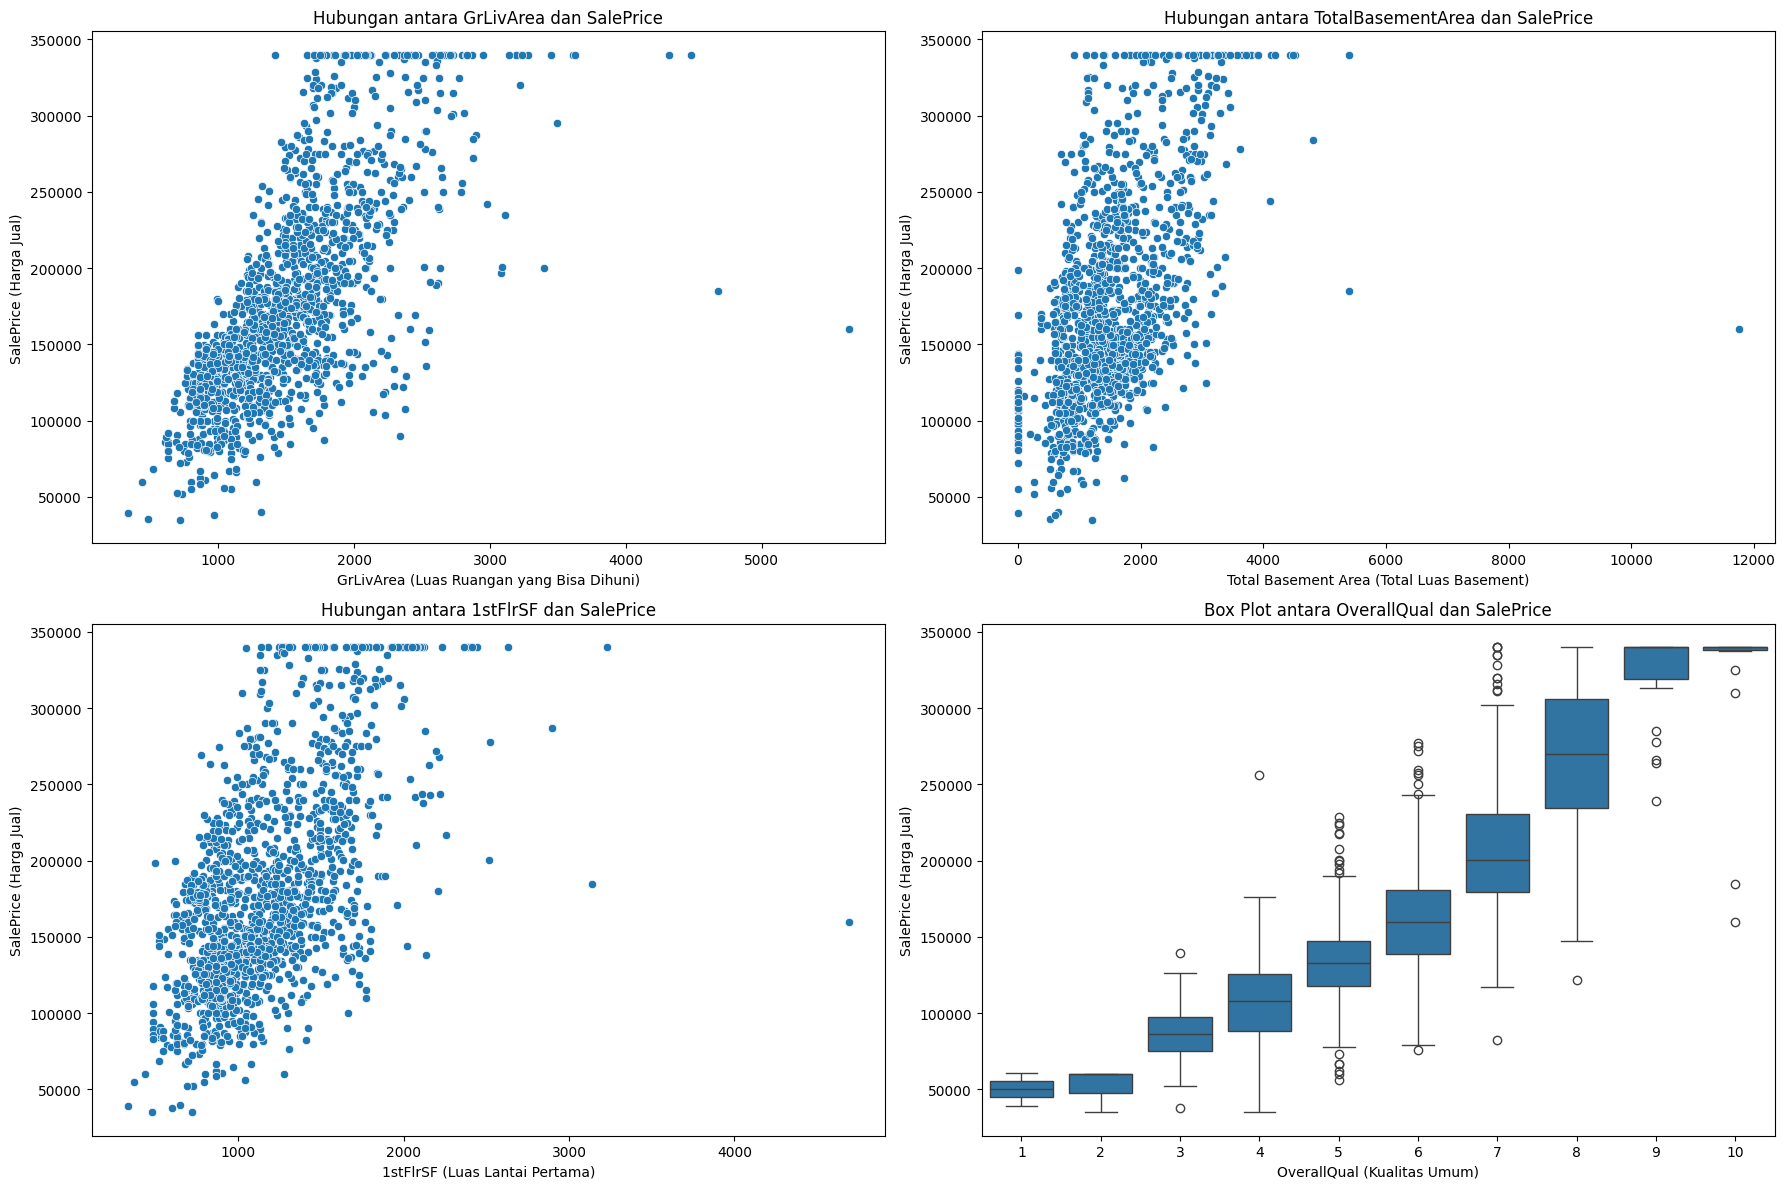

In [ ]:
# Feature Engineering
# 1. Usia Rumah
df_train['HouseAge'] = df_train['YrSold'] - df_train['YearBuilt']

# 2. Total Kamar Mandi
df_train['TotalBathrooms'] = df_train['BsmtFullBath'] + df_train['FullBath'] + (df_train['BsmtHalfBath'] * 0.5) + (df_train['HalfBath'] * 0.5)

# 3. Penggabungan Total Basement Area
df_train['TotalBasementArea'] = df_train['TotalBsmtSF'] + df_train['BsmtFinSF1'] + df_train['BsmtFinSF2']

# Visualisasi hubungan antara fitur dan SalePrice
plt.figure(figsize=(18, 12))

# 1. Scatter Plot untuk GrLivArea vs SalePrice
plt.subplot(2, 2, 1)
sns.scatterplot(x=df_train['GrLivArea'], y=df_train['SalePrice'])
plt.title('Hubungan antara GrLivArea dan SalePrice')
plt.xlabel('GrLivArea (Luas Ruangan yang Bisa Dihuni)')
plt.ylabel('SalePrice (Harga Jual)')

# 2. Scatter Plot untuk TotalBsmtSF vs SalePrice
plt.subplot(2, 2, 2)
sns.scatterplot(x=df_train['TotalBasementArea'], y=df_train['SalePrice'])
plt.title('Hubungan antara TotalBasementArea dan SalePrice')
plt.xlabel('Total Basement Area (Total Luas Basement)')
plt.ylabel('SalePrice (Harga Jual)')

# 3. Scatter Plot untuk 1stFlrSF vs SalePrice
plt.subplot(2, 2, 3)
sns.scatterplot(x=df_train['1stFlrSF'], y=df_train['SalePrice'])
plt.title('Hubungan antara 1stFlrSF dan SalePrice')
plt.xlabel('1stFlrSF (Luas Lantai Pertama)')
plt.ylabel('SalePrice (Harga Jual)')

# 4. Box Plot untuk OverallQual vs SalePrice
plt.subplot(2, 2, 4)
sns.boxplot(x=df_train['OverallQual'], y=df_train['SalePrice'])
plt.title('Box Plot antara OverallQual dan SalePrice')
plt.xlabel('OverallQual (Kualitas Umum)')
plt.ylabel('SalePrice (Harga Jual)')

# Atur layout dan tampilkan plot
plt.tight_layout()
plt.show()

In [ ]:
# Model Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, np.log(y_train))

# Prediksi
y_pred = linear_reg.predict(X_test)
y_pred_transformed = np.exp(y_pred)

# Handle NaN dan Inf
y_pred_transformed = np.where(np.isinf(y_pred_transformed), y_test.median(), y_pred_transformed)
y_pred_transformed = np.clip(y_pred_transformed, y_test.min(), y_test.max() * 2)

# Evaluasi
print(f"Linear Regression RMSE: {mean_squared_error(y_test, y_pred_transformed, squared=False)}")
print(f"Linear Regression R²: {r2_score(y_test, y_pred_transformed)}")

Linear Regression RMSE: 40866.93611434146
Linear Regression R²: 0.658412542213491


In [ ]:
# Random Forest
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid={
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_

# Prediksi
y_pred_rf = best_rf.predict(X_test)

# Evaluasi
print(f"Random Forest RMSE: {mean_squared_error(y_test, y_pred_rf, squared=False)}")
print(f"Random Forest R²: {r2_score(y_test, y_pred_rf)}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Random Forest RMSE: 20554.3852493671
Random Forest R²: 0.9135894553023187


In [ ]:
# XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search_xgb = GridSearchCV(estimator=xg_reg, param_grid={
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0]
}, cv=3, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_

# Prediksi
y_pred_xgb = best_xgb.predict(X_test)

# Evaluasi
print(f"XGBoost RMSE: {mean_squared_error(y_test, y_pred_xgb, squared=False)}")
print(f"XGBoost R²: {r2_score(y_test, y_pred_xgb)}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
XGBoost RMSE: 18999.049173584703
XGBoost R²: 0.9261719339789862


In [ ]:
# Ringkasan hasil evaluasi
print(f"Linear Regression RMSE: {mean_squared_error(y_test, y_pred_transformed, squared=False)}, R²: {r2_score(y_test, y_pred_transformed)}")
print(f"Random Forest RMSE: {mean_squared_error(y_test, y_pred_rf, squared=False)}, R²: {r2_score(y_test, y_pred_rf)}")
print(f"XGBoost RMSE: {mean_squared_error(y_test, y_pred_xgb, squared=False)}, R²: {r2_score(y_test, y_pred_xgb)}")

Linear Regression RMSE: 40866.93611434146, R²: 0.658412542213491
Random Forest RMSE: 20554.3852493671, R²: 0.9135894553023187
XGBoost RMSE: 18999.049173584703, R²: 0.9261719339789862


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Definisi ruang hiperparameter untuk Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Inisialisasi model Random Forest
rf = RandomForestRegressor(random_state=42)

# Tuning dng GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                                 scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Cari model terbaik
best_rf = grid_search_rf.best_estimator_
print("Best Hyperparameters for Random Forest:", grid_search_rf.best_params_)

# Prediksi dng model terbaik
y_pred_rf_best = best_rf.predict(X_test)

# Evaluasi
rmse_rf_best = mean_squared_error(y_test, y_pred_rf_best, squared=False)
r2_rf_best = r2_score(y_test, y_pred_rf_best)
print(f'Random Forest Best RMSE: {rmse_rf_best}')
print(f'Random Forest Best R²: {r2_rf_best}')


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
184 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best Hyperparameters for Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest Best RMSE: 21529.98022868269
Random Forest Best R²: 0.9051919923112922


In [ ]:
# Definisi ruang hiperparameter untuk XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Inisialisasi model XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Tuning dng GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xg_reg, param_grid=param_grid_xgb,
                                 scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

# Cari model terbaik
best_xgb = grid_search_xgb.best_estimator_
print("Best Hyperparameters for XGBoost:", grid_search_xgb.best_params_)

# Prediksi dng model terbaik
y_pred_xgb_best = best_xgb.predict(X_test)

# Evaluasi
rmse_xgb_best = mean_squared_error(y_test, y_pred_xgb_best, squared=False)
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)
print(f'XGBoost Best RMSE: {rmse_xgb_best}')
print(f'XGBoost Best R²: {r2_xgb_best}')


Fitting 3 folds for each of 405 candidates, totalling 1215 fits
Best Hyperparameters for XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
XGBoost Best RMSE: 18506.400945531444
XGBoost Best R²: 0.9299510399074812


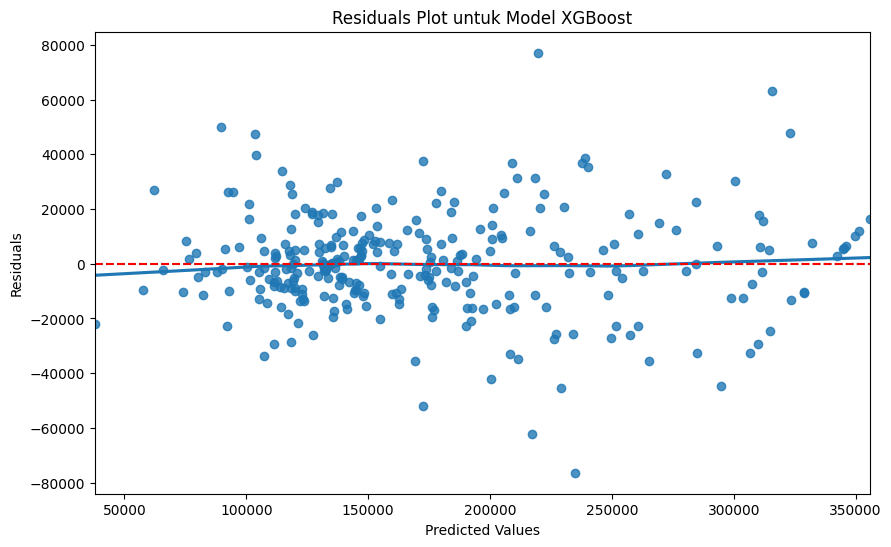

Top 10 Features Importance:
                  Importance
ExterQual_TA        0.451634
OverallQual         0.089780
GarageCars          0.047880
GarageFinish_Unf    0.045123
FireplaceQu_None    0.037626
KitchenQual_TA      0.023180
BsmtQual_Gd         0.021637
GrLivArea           0.019744
YearBuilt           0.014094
MSZoning_RM         0.012648


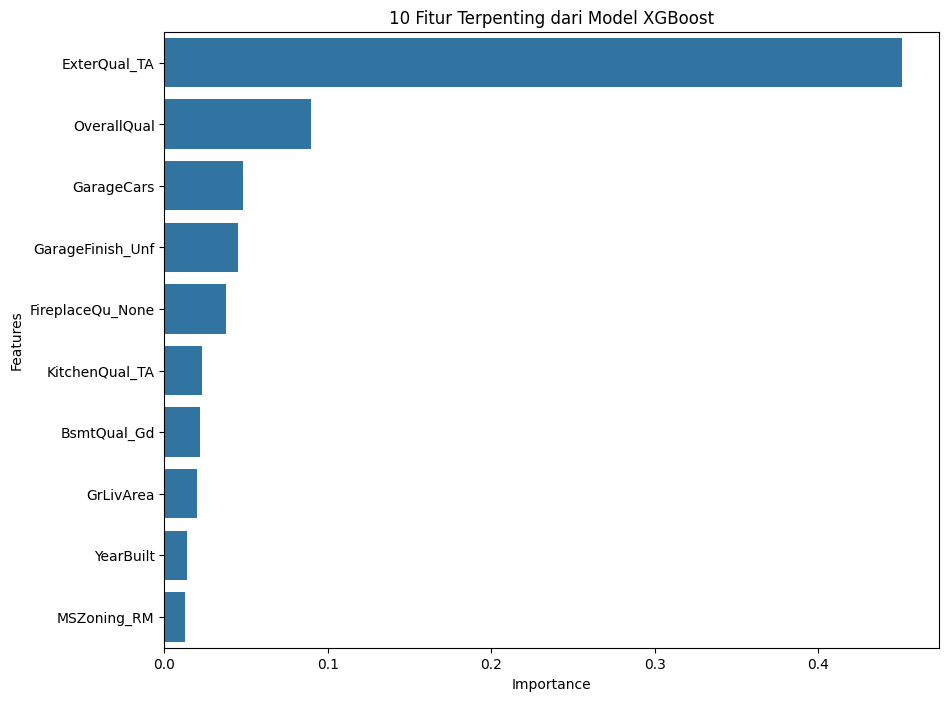

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Analisis Residual untuk model XGBoost
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_xgb_best, y=y_pred_xgb_best - y_test, lowess=True)
plt.title('Residuals Plot untuk Model XGBoost')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(0, linestyle='--', color='red') # Garis horizontal di nol
plt.show()

# Fitur Penting Model XGBoost
importance = best_xgb.feature_importances_
feature_importance = pd.DataFrame(importance, index=X_train.columns, columns=["Importance"]).sort_values("Importance", ascending=False)

# Ambil 10 Fitur Terpenting
top_10_features = feature_importance.head(10)
print("Top 10 Features Importance:")
print(top_10_features)

# Visualisasi 10 Fitur Terpenting
plt.figure(figsize=(10, 8))
sns.barplot(x=top_10_features['Importance'], y=top_10_features.index)
plt.title('10 Fitur Terpenting dari Model XGBoost')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


Penjelasan Mengapa Fitur Ini Penting


OverallQual:

Menilai kualitas keseluruhan material dan pekerjaan akhir rumah.
Pentingnya: Bahan dan hasil akhir yang berkualitas meningkatkan keinginan dan nilai rumah, yang secara langsung mempengaruhi harga jual.


GrLivArea:

Luas ruang yang dapat dihuni di atas tanah.
Pentingnya: Ruang hidup yang lebih besar biasanya menyebabkan harga lebih tinggi. Ini adalah salah satu alat prediksi harga yang paling intuitif, karena pembeli membayar lebih untuk ruang ekstra.


TotalBsmtSF:

Total luas basement dalam kaki persegi.
Pentingnya: Ruang bawah tanah dapat menambah ruang hidup secara signifikan atau mengurangi nilai keseluruhan jika kualitasnya buruk. Oleh karena itu, basement yang diselesaikan dengan baik biasanya berdampak positif terhadap harga jual.


YearBuilt:

Tahun konstruksi awal rumah.
Pentingnya: Rumah baru sering kali memiliki label harga premium karena fasilitas modern dan berkurangnya kebutuhan perbaikan, menjadikan fitur ini penting dalam memprediksi harga.


GarageCars:

Kapasitas mobil di garasi.
Pentingnya: Garasi sangat dihargai di banyak pasar perumahan; dengan demikian, lebih bermanfaat untuk rumah dengan kapasitas parkir lebih besar.


OverallCond:

Menilai kondisi umum rumah.
Pentingnya: Peringkat yang lebih tinggi menunjukkan pemeliharaan dan kebersihan yang lebih baik, yang umumnya menghasilkan harga jual yang lebih tinggi.


TotalBathrooms:

Total jumlah kamar mandi (menggabungkan full dan half baths).
Pentingnya: Kamar mandi yang lebih banyak dapat membuat rumah lebih menarik bagi calon pembeli, terutama bagi keluarga besar.


1stFlrSF:

Luas lantai pertama.
Pentingnya: Mirip dengan GrLivArea, ukuran luas lantai pertama seringkali penting dalam menentukan ruang hidup secara keseluruhan.


TotRmsAbvGrd:

Total jumlah ruangan di atas tanah (tidak termasuk kamar mandi).
Pentingnya: Semakin banyak ruangan, semakin tinggi pula utilitas yang dinilai pembeli saat menentukan harga jual.


Fireplaces:

Jumlah perapian dalam rumah.
Pentingnya: Memiliki perapian sering kali dipandang sebagai fitur yang diinginkan yang meningkatkan estetika dan suasana, yang secara positif dapat mempengaruhi harga.

In [ ]:
# Membuat fitur interaksi
df_train['OverallQual_GrLivArea'] = df_train['OverallQual'] * df_train['GrLivArea']
df_train['OverallQual_TotalBsmtSF'] = df_train['OverallQual'] * df_train['TotalBsmtSF']


In [ ]:
from sklearn.linear_model import LinearRegression

# Memisahkan antara fitur (X) dan target (y)
X = df_train[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'TotalBathrooms',
               'YearBuilt', '1stFlrSF', 'TotRmsAbvGrd', 'Fireplaces', 'OverallCond',
               'OverallQual_GrLivArea', 'OverallQual_TotalBsmtSF']]
y = df_train['SalePrice']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model regresi
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Prediksi
y_pred = linear_reg.predict(X_test)

# Evaluasi
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R²: {r2_score(y_test, y_pred)}")

# Menampilkan koefisien
coef_df = pd.DataFrame(linear_reg.coef_, X.columns, columns=['Coefficients'])
print(coef_df)


RMSE: 25723.81785630855
R²: 0.864659240311305
                         Coefficients
OverallQual              18263.567608
GrLivArea                   17.979681
TotalBsmtSF                 28.359598
GarageCars               13475.311502
TotalBathrooms            9605.220578
YearBuilt                  387.624948
1stFlrSF                    15.181115
TotRmsAbvGrd               878.363480
Fireplaces                9635.960467
OverallCond               6233.246949
OverallQual_GrLivArea        1.127928
OverallQual_TotalBsmtSF     -3.092620


Hasil Analisis Regresi
RMSE: 25,723.82
R²: 0.865
Interpretasi:

RMSE yang relatif tinggi (25,723.82) menunjukkan bahwa terdapat variasi yang cukup besar antara prediksi dan harga yang aktual. Namun, nilai R² yang mendekati 0.865 menunjukkan bahwa model dapat menjelaskan sekitar 86.5% dari variasi dalam SalePrice, yang bisa dianggap baik untuk model regresi.
Koefisien Fitur
Koefisien regresi memberikan wawasan yang berharga tentang pengaruh setiap fitur. Berikut adalah analisis untuk setiap fitur:

OverallQual: 18,263.57

Menunjukkan bahwa setiap unit peningkatan dalam kualitas keseluruhan material dan penyelesaian rumah diperkirakan akan meningkatkan harga jual sebesar sekitar $18,263.57.
GrLivArea: 17.98

Untuk setiap kaki persegi tambahan di ruang hunian di atas tanah, harga diperkirakan akan meningkat sebesar $17.98. Meskipun ini terlihat kecil, bila diterapkan pada luas yang lebih besar, dampaknya akan signifikan.
TotalBsmtSF: 28.36

Setiap kaki persegi tambahan di basement diharapkan meningkatkan harga jual sebesar $28.36.
GarageCars: 13,475.31

Menyetujui bahwa setiap mobil tambahan yang dapat diparkir di garasi diperkirakan meningkatkan harga jual sebesar $13,475.31. Fitur ini memperlihatkan nilai garasi yang tinggi.
TotalBathrooms: 9,605.22

Setiap tambahan kamar mandi diperkirakan dapat meningkatkan harga jual sebesar $9,605.22. Fitur ini sangat berharga bagi pembeli rumah.
YearBuilt: 387.62

Setiap tahun tambahan usia rumah diperkirakan mengurangi harga jual sebesar $387.62, meskipun ini menunjukkan bahwa rumah baru adalah nilai tambah.
1stFlrSF: 15.18

Setiap kaki persegi tambahan pada lantai pertama diperkirakan meningkatkan harga jual sebesar $15.18.
TotRmsAbvGrd: 878.36

Setiap ruangan tambahan di atas tanah (tidak termasuk kamar mandi) meningkatkan harga jual sebesar $878.36, menunjukkan bahwa lebih banyak ruang meningkatkan nilai properti.
Fireplaces: 9,635.96

Memiliki satu perapian tambahan diperkirakan meningkatkan harga rumah sebesar $9,635.96. Pembeli rumah sering kali menghargai fitur ini.
OverallCond: 6,233.25

Mencerminkan bahwa untuk setiap unit peningkatan dalam kondisi keseluruhan rumah, ada peningkatan harga jual sebesar $6,233.25.
OverallQual_GrLivArea: 1.13

Ini adalah interaksi antara kualitas keseluruhan dan luas ruang yang bisa dihuni, dan menunjukkan adanya peningkatan kecil yang signifikan pada hubungan keduanya.
OverallQual_TotalBsmtSF: -3.09

Menunjukkan bahwa jika kualitas keseluruhan meningkat, tetapi luas basement menurun (interaksi negatif), mungkin mengurangi nilai rumah. Hal ini menunjukkan pentingnya keseimbangan antara faktor-faktor tersebut.

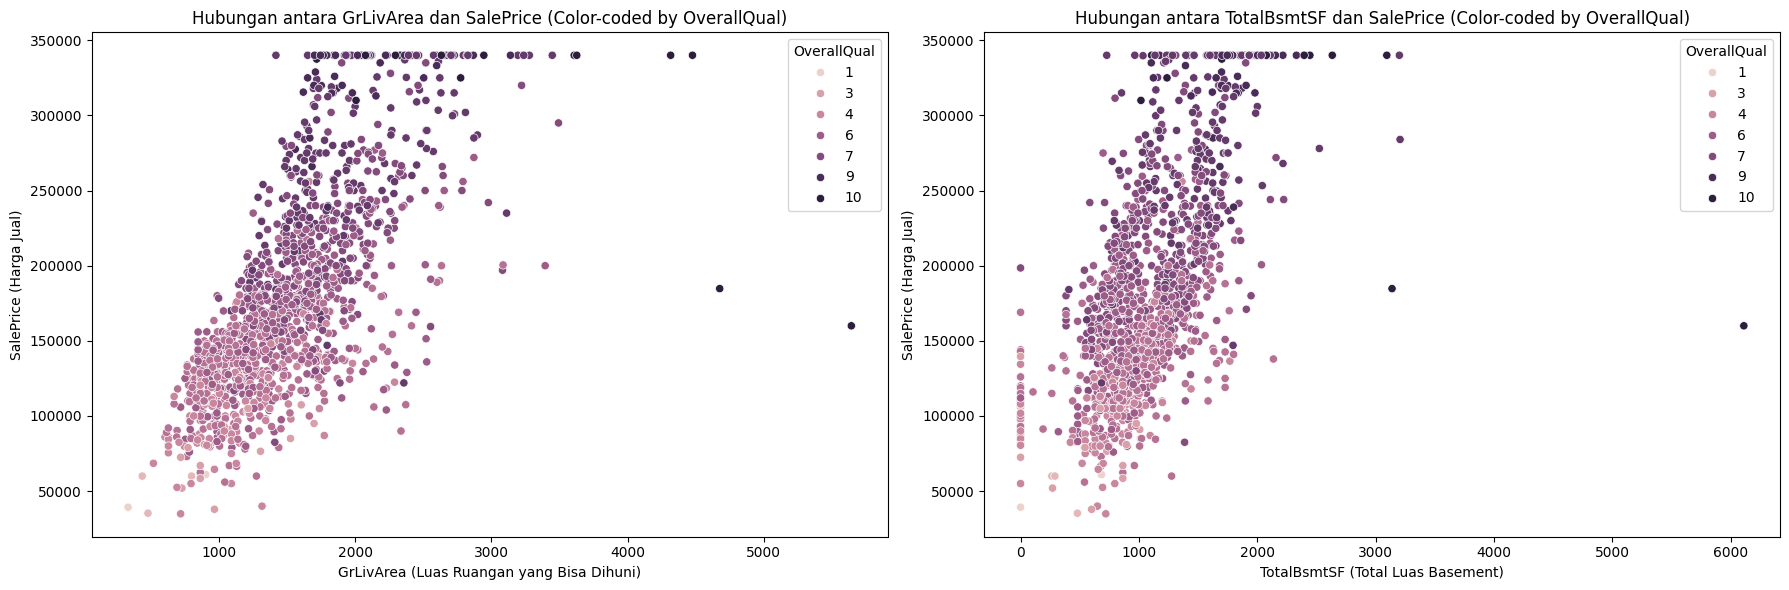

In [ ]:
# Visualisasi Interaksi
plt.figure(figsize=(18, 6))

# Interaksi OverallQual vs GrLivArea
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_train['GrLivArea'], y=df_train['SalePrice'], hue=df_train['OverallQual'])
plt.title('Hubungan antara GrLivArea dan SalePrice (Color-coded by OverallQual)')
plt.xlabel('GrLivArea (Luas Ruangan yang Bisa Dihuni)')
plt.ylabel('SalePrice (Harga Jual)')

# Interaksi OverallQual vs TotalBsmtSF
plt.subplot(1, 2, 2)
sns.scatterplot(x=df_train['TotalBsmtSF'], y=df_train['SalePrice'], hue=df_train['OverallQual'])
plt.title('Hubungan antara TotalBsmtSF dan SalePrice (Color-coded by OverallQual)')
plt.xlabel('TotalBsmtSF (Total Luas Basement)')
plt.ylabel('SalePrice (Harga Jual)')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

# Model Random Forest
rf = RandomForestRegressor(random_state=42,
                            max_depth=20,
                            n_estimators=300,
                            max_features='sqrt',
                            min_samples_split=2,
                            min_samples_leaf=1)

# Melakukan cross-validation
rf_cv_scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error')

# Hitung RMSE dari nilai CV
rf_cv_rmse = np.sqrt(-rf_cv_scores)
print("Random Forest - Cross-Validation RMSE: ", rf_cv_rmse)
print("Mean RMSE (Random Forest): ", rf_cv_rmse.mean())
print("Standard Deviation RMSE (Random Forest): ", rf_cv_rmse.std())

# Model XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror',
                           random_state=42,
                           colsample_bytree=0.6,
                           learning_rate=0.1,
                           max_depth=3,
                           n_estimators=300,
                           subsample=0.8)

# Melakukan cross-validation
xgb_cv_scores = cross_val_score(xg_reg, X, y, cv=5, scoring='neg_mean_squared_error')

# Hitung RMSE dari nilai CV
xgb_cv_rmse = np.sqrt(-xgb_cv_scores)
print("XGBoost - Cross-Validation RMSE: ", xgb_cv_rmse)
print("Mean RMSE (XGBoost): ", xgb_cv_rmse.mean())
print("Standard Deviation RMSE (XGBoost): ", xgb_cv_rmse.std())


Random Forest - Cross-Validation RMSE:  [24046.26693136 23583.81563089 23572.73351262 19567.70638361
 23988.08874887]
Mean RMSE (Random Forest):  22951.72224146922
Standard Deviation RMSE (Random Forest):  1703.457894632614
XGBoost - Cross-Validation RMSE:  [21963.60096644 22210.01129744 22532.45327158 17559.90555987
 21357.91703173]
Mean RMSE (XGBoost):  21124.77762541191
Standard Deviation RMSE (XGBoost):  1823.489746153298


Ringkasan Hasil Cross-Validation Random Forest: RMSE per Fold: 24,046.27 23,583.82 23,572.73 19,567.71 23,988.09 Mean RMSE: 22,951.72 Standard Deviation RMSE: 1,703.46 XGBoost: RMSE per Fold: 21,963.60 22,210.01 22,532.45 17,559.91 21,357.92 Mean RMSE: 21,124.78 Standard Deviation RMSE: 1,823.49 Interpretasi Hasil Stabilitas Model:

Random Forest memiliki standard deviation (SD) yang lebih rendah (1,703.46) dibandingkan dengan XGBoost (1,823.49). Ini menunjukkan bahwa Random Forest lebih konsisten dalam memberikan hasil yang mirip di setiap fold dari k-fold cross-validation. Performa Keseluruhan:

XGBoost memiliki Mean RMSE yang lebih rendah (21,124.78) dibandingkan dengan Random Forest (22,951.72), sehingga XGBoost menunjukkan performa prediksi yang lebih baik secara keseluruhan. Meskipun Random Forest lebih stabil, XGBoost menunjukkan kemampuan prediksi yang lebih akurat untuk data ini.